## SCR: Feedforward NN and Convolutional NN

In [1]:
import numpy as np
import SCRpreprocess
import pandas as pd
import numpy as np
#%matplotlib inline

#Fixed Random Seed for Reproducability (ACHTUNG WEGEN LOOPED CV)
seed = 42
np.random.seed(seed)

from keras.utils import np_utils

#get the data and prepocess them
# resolution: 50, 100 or 500
# zstand: 0/1
# method: division/subtraction/raw
# outlier=orig/sd/iq
data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw', 
                                                                            zstand=1, resolution=50, outl='orig')

print data.columns
#function for what to predict and on which data base
def what_to_predict(data, aim, grouped, subframe):
    #fill up missing values (ffill=use last observation)
    data=data.fillna(method='ffill')

    print 'prediction of ' + aim
    #for valence the pos. and neg. values have to be recoded to 0 and 1
    data.loc[(data['val']=='pos'), 'val']=1
    data.loc[(data['val']=='neg'), 'val']=0
    
    data.loc[(data['gen']=='male'), 'gen']=1
    data.loc[(data['gen']=='female'), 'gen']=0

    #makes prediction aim numeric
    data[aim]=pd.to_numeric(data[aim])
        
    #Group by pics vpns or nothing and produce a dataframe with as much inforation as possible
    if grouped=='not':
        if subframe=='cog':
            data=data[data.con==1].reset_index(drop=True)
            print 'only cognitive task' 
        if subframe=='emo':
            data=data[data.con==2].reset_index(drop=True)
            print 'only emo task' 
        print 'trialbased-prediction'
    else:
        if grouped=='pic':          
            X=np.array(data.groupby([grouped]).mean()[scl_s]) 
            y=np.array(data.groupby([grouped]).mean()[aim])         
            
        if grouped=='vpn':
            emo_pos_df=data.loc[(data.con==2)&(data.val==1)].groupby([grouped]).mean()
            emo_neg_df=data.loc[(data.con==2)&(data.val==0)].groupby([grouped]).mean()

            cog_pos_df=data.loc[(data.con==1)&(data.val==1)].groupby([grouped]).mean()
            cog_neg_df=data.loc[(data.con==1)&(data.val==0)].groupby([grouped]).mean()
            #X=np.hstack([emo_pos_df[scl_s], emo_neg_df[scl_s], cog_pos_df[scl_s], cog_neg_df[scl_s]])
            #y=np.array(emo_pos_df[aim])
            
            pos_df=data.loc[(data.val==1)].groupby([grouped]).mean()
            neg_df=data.loc[(data.val==0)].groupby([grouped]).mean()
            
            X=np.hstack([pos_df[scl_s], neg_df[scl_s]])
            y=np.array(pos_df[aim])
            
            if subframe=='emo':
                emop_df=data.loc[(data.con==2) & (data.val==0)].groupby([grouped]).mean()
                emon_df=data.loc[(data.con==2) & (data.val==1)].groupby([grouped]).mean()
                X=np.hstack([emop_df[scl_s], emon_df[scl_s]])
                y=np.array(emop_df[aim])
            if subframe=='cog':
                cog_df=data.loc[(data.con==1)].groupby([grouped]).mean()
                X=np.array(cog_df[scl_s])
                y=np.array(cog_df[aim])
                
    #shuffle the data 
    indices=np.arange(len(X))
    np.random.shuffle(indices)
    X=X[indices]
    y=y[indices]
    df=(data.groupby([grouped]).mean())
    idf=df.index[indices]
   
    return X,y, idf

Using Theano backend.


no outlier detection
raw
Index([u'VPN', u'SPF_SUM', u'SPF_FS_SUM', u'SPF_EC_SUM', u'SPF_PT_SUM',
       u'SPF_PD_SUM', u'SPF_Empathy_SUM', u'AQsum', u'NPIgesamt', u'SOCsum',
       ...
       u'pic', u'con', u'key', u'cor', u'time', u'gen', u'age', u'val',
       u'date', u'all'],
      dtype='object', length=579)


# The Data

## SCR as a reaction to the valence of the pic

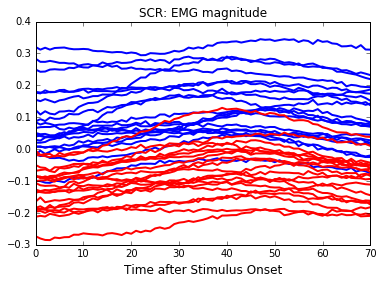

In [288]:
## same for different dataframes
import numpy as np
from scipy import stats

def skin_graph(dfA, dfB, scl_s, group2, filename,  errors=False):

    import matplotlib.pyplot as plt

    groups= dfA[scl_s].groupby(dfA[group2])
    
    for name, group in groups:    
        y=np.transpose(np.array(group.mean()))
        if errors==False:
            plt.plot(y, linewidth=2.0, linestyle="-", color='b')
        else: 
            x=np.arange(0,(len(y)))
            error=stats.sem(group, nan_policy='omit')
            plt.errorbar(x, y, error, ms=20, mew=4, linewidth=2.0, linestyle="-",  color='b', label='pos')

    groups= dfB[scl_s].groupby(dfB[group2])
    
    for name, group in groups:
        y=np.transpose(np.array(group.mean()))
        
        if errors==False:
            plt.plot(y, linewidth=2.0, linestyle="-", color='r')
        else: 
            x=np.arange(0,(len(y)))
            error=stats.sem(group, nan_policy='omit')
            plt.errorbar(x, y, error, ms=20, mew=4, linewidth=2.0, linestyle="-",  color='r', label='neg')
    plt.title('SCR: EMG magnitude')
    plt.xlabel('Time after Stimulus Onset', fontsize=12.0)
    plt.legend()    
    plt.show()   
    
skin_graph(data[data.val=='pos'], data[data.val=='neg'], scl_s, group2='pic', filename='scr_trigger.png')

## SCR as a reaction to male and female pics

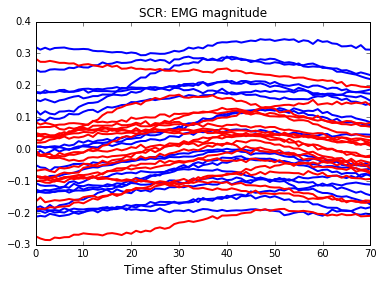

2600
2600


In [289]:
skin_graph(data[data.gen=='female'], data[data.gen=='male'], scl_s, group2='pic', filename='scr_trigger.png')
print len(data[data.gen=='female'])
print len(data[data.gen=='male'])

## Autistic Traits

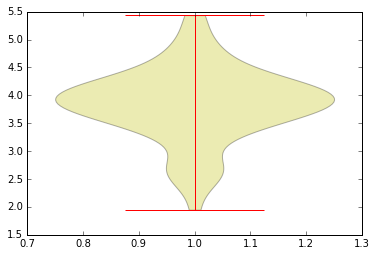

In [323]:
df_vpn=data.groupby(['vpn']).mean()
plt.violinplot([df_vpn.key])
plt.show()

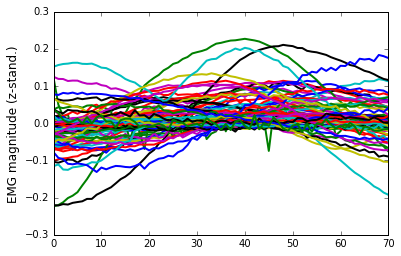

In [296]:
def individual_graph(df, column):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    index=set(df[column].values)

    for item in index:
        scl= df.loc[(df[column]==item)][scl_s] 
        plt.plot(np.transpose(np.array(scl.mean())), linewidth=2.0, linestyle="-", label='scl')
        plt.title('EMG responses of all Participants')
        plt.xlabel('time', fontsize=12.0)
        plt.ylabel('EMG magnitude (z-stand.)', fontsize=12.0)      
plt.show()
        
column='vpn'
individual_graph(data, column)

# Predicting the valence of the picture from the SCR (Classfication Problem)

## Feed-Forward Network 

In [312]:
#from sklearn.model_selection import train_test_split
np.random.seed(seed)

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='division',
                                                                                          zstand=0, resolution=50)

X,y, idf =what_to_predict(data, 'val', 'pic', 'all')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #split the data

batch_size=20 #number of instances that are evaluated befoe a weight update is performed 
nb_epoch=5 #Epoch=numbers of iterations of the training process

model = Sequential() #sequence of layers
model.add(Dense(50, init='normal', activation='relu', input_dim=X_train.shape[1],))
#                W_regularizer=l2(1e+4), bias=False, input_dim=X_train.shape[1],))
#Fully-Connected Layer with 20 neurons
#input_dim=how many input variables
#init=how to intitialise network weights ('normal' - small random numbers from a normal distr., 'uniform')
#activation=activation function ('relu' max(0,actv) , 'sigmoid'- between 0 and 1 , 'softmax' - probs. for classes)
#no bias units
#l2-reqularisierer-small weights

model.add(Dense(20, init='normal', activation='relu', W_regularizer=l2(1e+4), bias=False))
model.add(Dense(1, init='normal', activation='sigmoid')) #outputlayer
model.summary() #description of the network

model.compile(loss='binary_crossentropy',  optimizer='sgd', metrics=['accuracy'])
# binary_crossentropy“ = logarithmic loss function for a binary classification problem
# efficient gradient descent algorithm: “adam” 
# acc=number of correct predictions made divided by the total number of predictions made

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test) 
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

no outlier detection
baseline division
prediction of val
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_8106 (Dense)               (None, 50)            3600        dense_input_4[0][0]              
____________________________________________________________________________________________________
dense_8107 (Dense)               (None, 20)            1000        dense_8106[0][0]                 
____________________________________________________________________________________________________
dense_8108 (Dense)               (None, 1)             21          dense_8107[0][0]                 
Total params: 4621
____________________________________________________________________________________________________
Train on 28 samples, validate on 12 samples
Epoch 1/5
28/28 [==============================] - 0s - loss: 262132534.

## Convolutional Network

no outlier detection
raw
prediction of val
14/14 [==============================] - 0s
acc: 78.57%
14/14 [==============================] - 0s
acc: 85.71%
12/12 [==============================] - 0s
acc: 100.00%


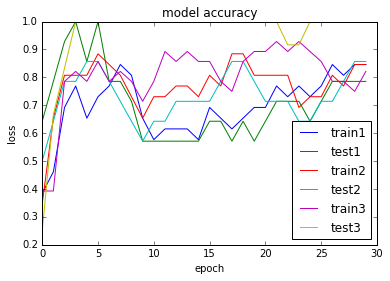

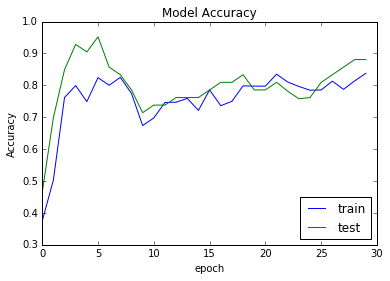

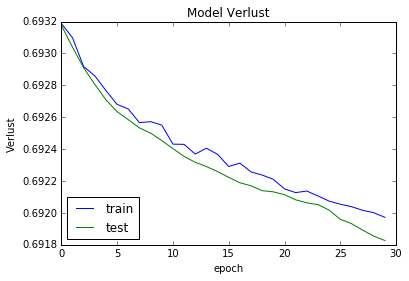

['82.jpg']


(71L,)


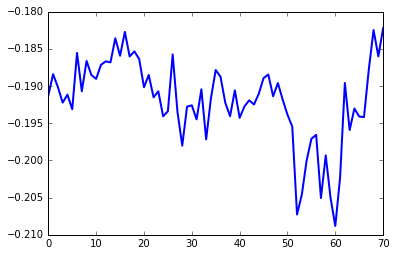

(10L, 67L)


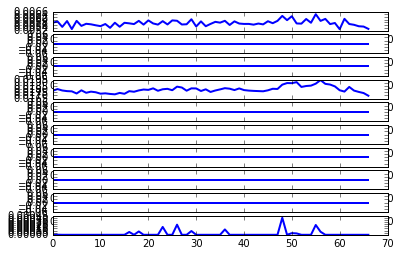

In [315]:
#from sklearn.model_selection import train_test_split
#Fixed Random Seed for Reproducability (ACHTUNG WEGEN LOOPED CV)
np.random.seed(seed)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D

import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold


data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw',
                                                                                          zstand=1, resolution=50)
X,y, idf =what_to_predict(data, 'val', 'pic', 'all')

nb_filters = 10
nb_conv = 5
epochs = 30
lrate = 0.0001

history=[]
acc_cv=[]
acc_val_cv=[]
loss_cv=[]
loss_val_cv=[]

skf = StratifiedKFold(y, n_folds=3, shuffle=True)

for train, test in skf: 
    
    X_train=X[train]
    X_test=X[test]
    y_train=y[train]
    y_test=y[test]
    Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D())
    model.add(Convolution1D(nb_filters*2, nb_conv, activation='relu'))#, input_length=X_train.shape[1], input_dim=1))
    model.add(MaxPooling1D())
    model.add(Dropout(0.1))
    model.add(Flatten()) 
    model.add(Dense(72, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    from keras.optimizers import SGD
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

    
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
    #model.summary()
    history=model.fit(Xr_train, y_train, validation_data=(Xr_test, y_test),  
                      nb_epoch=epochs, batch_size=5, verbose=0)
    score = model.evaluate(Xr_test, y_test)
    
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    acc_cv.append(history.history['acc'])
    acc_val_cv.append(history.history['val_acc'])
    
    loss_cv.append(history.history['loss'])
    loss_val_cv.append(history.history['val_loss'])
    
    #print acc_cv
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train1', 'test1', 'train2', 'test2', 'train3', 'test3'], loc='lower right')

plt.show()

visualise_acc(acc_cv, acc_val_cv)
visualise_loss(loss_cv, loss_val_cv)
bild_prediction(model, idf)
visualise_weights(model)

## Vorhersage der abgebildeten Person

no outlier detection
raw
prediction of gen
14/14 [==============================] - 0s
0.785714268684
14/14 [==============================] - 0s
0.642857134342
12/12 [==============================] - 0s
0.583333313465


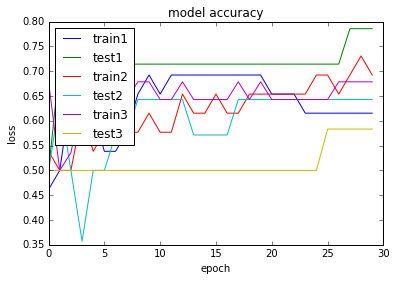

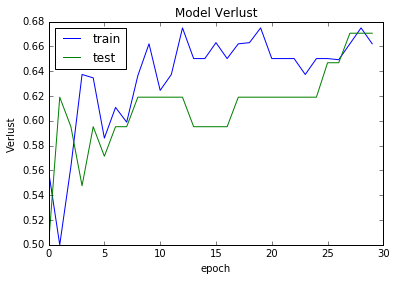

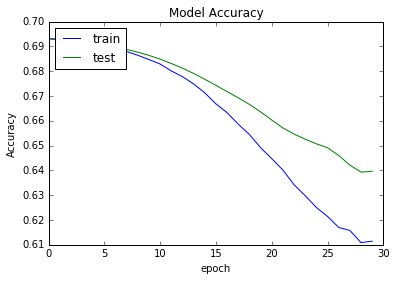

['73.jpg']


(71L,)


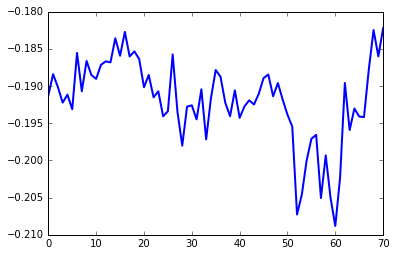

(25L, 67L)


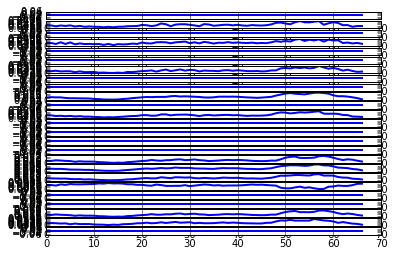

In [302]:
#from sklearn.model_selection import train_test_split
#Fixed Random Seed for Reproducability (ACHTUNG WEGEN LOOPED CV)
np.random.seed(seed)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D

import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold


data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw',
                                                                                          zstand=1, resolution=50)
X,y, idf =what_to_predict(data, 'gen', 'pic', 'all')

nb_filters = 25
nb_conv = 5
epochs = 30

history=[]
acc_cv=[]
acc_val_cv=[]
loss_cv=[]
loss_val_cv=[]


skf = StratifiedKFold(y, n_folds=3, shuffle=True)

for train, test in skf: 
    X_train=X[train]
    X_test=X[test]
    y_train=y[train]
    y_test=y[test]
        
    Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D())
    model.add(Convolution1D(nb_filters*2, nb_conv, activation='relu'))#, input_length=X_train.shape[1], input_dim=1))
    model.add(MaxPooling1D())
    model.add(Dropout(0.1))
    model.add(Flatten()) 
    model.add(Dense(72, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

   
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    #model.summary()
    history=model.fit(Xr_train, y_train, validation_data=(Xr_test, y_test), verbose=0,  
                      nb_epoch=epochs, batch_size=40)
    score = model.evaluate(Xr_test, y_test)
    
    print score[1]
    acc_cv.append(history.history['acc'])
    acc_val_cv.append(history.history['val_acc'])
    
    loss_cv.append(history.history['loss'])
    loss_val_cv.append(history.history['val_loss'])
    
    #print acc_cv
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train1', 'test1', 'train2', 'test2', 'train3', 'test3'], loc='upper left')

plt.show()

visualise_acc(acc_cv, acc_val_cv)
visualise_loss(loss_cv, loss_val_cv)
bild_prediction(model, idf)
visualise_weights(model)

## Hyperparameter-Tuning

## Tuning der number of filters und der Größe der Filter

In [216]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
import SCRpreprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit

data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw', 
                                                                                          zstand=1, resolution=50)

X,y,idf=what_to_predict(data, 'val', 'pic', 'all')

def tune_filter(X,y):

    history=[]

    def create_model(nb_filters=5, nb_conv=2):
        model = Sequential()
        model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X.shape[1], 1)))
        model.add(MaxPooling1D())
        model.add(Convolution1D(2*nb_filters, nb_conv, activation='relu'))
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        model.add(Flatten())  
        model.add(Dense(72, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        sgd = SGD(lr=0.05, momentum=0.4)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
        return model


    skf = StratifiedKFold(y, n_folds=3, shuffle=True)
    mean_acc=0.0

    #Stratified KFold
    for train, test in skf:
        X_train=X[train]
        X_test=X[test]
        y_train=y[train]
        y_test=y[test]

        Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        model = KerasClassifier(build_fn=create_model, nb_epoch=25, batch_size=5, verbose=0)
        # define the grid search parameter25
        nb_filters = [2, 4, 6, 8, 10, 12]          
        nb_conv = [2, 4, 6, 8, 10]

        param_grid = dict(nb_filters=nb_filters, nb_conv=nb_conv)
        grid = GridSearchCV(cv=5, estimator=model, param_grid=param_grid)    
        grid_result = grid.fit(Xr_train, y_train)
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        return skf
tune_filter(X,y)  

no outlier detection
raw
prediction of val
Best: 0.769231 using {'nb_conv': 8, 'nb_filters': 10}
Best: 1.000000 using {'nb_conv': 10, 'nb_filters': 6}
Best: 0.964286 using {'nb_conv': 8, 'nb_filters': 12}


### Tuning der Lernrate

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
import SCRpreprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from keras.optimizers import SGD

data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw', 
                                                                                          zstand=1, resolution=50)

X,y,_=what_to_predict(data, 'val', 'pic', 'all')

tune_lr(X,y):
    def create_model(learn_rate=0.01, momentum=0.4):
        nb_filters = 8
        nb_conv = 8
        model = Sequential()
        model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X.shape[1], 1)))
        model.add(MaxPooling1D())
        model.add(Convolution1D(2*nb_filters, nb_conv, activation='relu'))
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        model.add(Flatten())  
        model.add(Dense(72, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        sgd = SGD(lr=learn_rate, decay=(learn_rate/25), momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
        return model


    skf = StratifiedKFold(y, n_folds=3, shuffle=True)
    mean_acc=0.0

    for train, test in skf:
        X_train=X[train]
        X_test=X[test]
        y_train=y[train]
        y_test=y[test]

        Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        model = KerasClassifier(build_fn=create_model, nb_epoch=25, batch_size=5, verbose=0)
        # define the grid search parameters
        learn_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
        momentum = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]

        param_grid = dict(learn_rate=learn_rate, momentum=momentum)
        grid = GridSearchCV(cv=3, estimator=model, param_grid=param_grid)
        grid_result = grid.fit(Xr_train, y_train)
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        return skf
tune_lr(X,y)

### Visualisierung der Accuracy und des Verlustes

In [314]:
def visualise_acc(acc_cv, acc_val_cv):
    plt.plot(np.mean(acc_cv, axis=0))
    plt.plot(np.mean(acc_val_cv, axis=0))
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()
    
def visualise_loss(loss_cv, loss_val_cv):    
    plt.plot(np.mean(loss_cv, axis=0))
    plt.plot(np.mean(loss_val_cv, axis=0))
    plt.title('Model Verlust')
    plt.ylabel('Verlust')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower left')
    plt.show()

### Visualisierung der Gewichte

In [213]:
def visualise_weights(model):
    
    W=model.layers[0].get_weights()[0]
    import matplotlib.pyplot as plt

    W = np.reshape(W,[W.shape[0],W.shape[1], W.shape[2]])
    fig = plt.figure()
    for i in np.arange(len(W)):
        fig.add_subplot(len(W),1,i+1)
        #plt.title('conv1 weights')
        plt.imshow(W[i,:,:], cmap='Greys_r')
        #splt.axes.get_yaxis().set_visible(False)
        plt.axis('off')
    plt.show()


    # picture of the first scr-response
    plt.plot(X[0,:], linewidth=2.0, linestyle="-")
    print X[0,:].shape
    plt.show()


    # picture of the filtered versions of the first scr-response
    Xn = np.reshape(X, (X.shape[0], X.shape[1], 1))
    model2 = Sequential()
    model2.add(Convolution1D(nb_filters, nb_conv, activation='relu', 
                             input_shape=(Xn.shape[1], 1), weights=model.layers[0].get_weights()))

    activations=model2.predict(Xn[0:1,:,:])
    activations=np.squeeze(activations).T
    print(activations.shape)
    fig = plt.figure()
    for i in np.arange(len(activations)):    
        fig.add_subplot(len(activations),1,i+1)
        plt.plot(activations[i], linewidth=2.0, linestyle="-")
    plt.show()

(71L,)
(25L, 67L)


### Fitting with all data and Predicting values

In [16]:
#model fit mit allen Daten
def predict_final(X, model):
    Xr = np.reshape(X, (X.shape[0], X.shape[1], 1))
    model.fit(Xr, y, nb_epoch=epochs, batch_size=batch)
    predictions = model.predict(Xr_test)
    # round predictions (because we have class probability between 0 and 1)
    rounded = [round(x[0]) for x in predictions]
    print(rounded)

[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]


### Bilder mit stärkster Prediction

In [240]:
def bild_prediction(model, idf):
    import matplotlib.image as mpimg
    preds=model.predict(np.reshape(X, (X.shape[0], X.shape[1], 1)))
    idf=np.array(idf)
    maxima=np.array(preds==max(preds))
    minima=np.array(preds==min(preds))
    indexmax= idf[maxima[:,0]]
    indexmin= idf[minima[:,0]]
    fig, (ax1, ax2)=plt.subplots(1,2)
    image1 = mpimg.imread('pics/' + indexmax[0])
    image2 = mpimg.imread('pics/' + indexmin[0])
    ax1.imshow(image1)
    ax1.axis('off')
    ax2.imshow(image2)
    ax2.axis('off')
    plt.show()

['73.jpg']


## What does the SCR tells us about the personality of a participant? (Regression Problem)

## Parameter-Tuning

In [286]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
import SCRpreprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.cross_validation import StratifiedShuffleSplit

data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='subtraction', 
                                                                                          zstand=1, resolution=50)

X,y, _=what_to_predict(data, 'key', 'vpn', 'emo')

def tune_AQ(X,y):
    stats.zscore(y)

    history=[]

    def create_model(nb_filters=5, nb_conv=2):
        model = Sequential()
        model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X.shape[1], 1)))
        model.add(MaxPooling1D())
        model.add(Convolution1D(2*nb_filters, nb_conv, activation='relu'))
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        model.add(Flatten())  
        model.add(Dense(72, activation='relu'))
        model.add(Dense(1))
        sgd = SGD(lr=0.1, decay=0.1/25, momentum=0.9)
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        return model


    kf = KFold(n_splits=3, shuffle=True)
    mean_acc=0.0

    #Stratified KFold
    for train, test in kf.split(X):
        X_train=X[train]
        X_test=X[test]
        y_train=y[train]
        y_test=y[test]

        Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        model = KerasClassifier(build_fn=create_model, nb_epoch=40, batch_size=10, verbose=0)
        # define the grid search parameter25
        nb_filters = [2, 4,  6, 8, 10, 15, 20, 30]          
        nb_conv = [2, 4, 6, 8, 10]

        param_grid = dict(nb_filters=nb_filters, nb_conv=nb_conv)
        grid = GridSearchCV(cv=5, estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error')    
        grid_result = grid.fit(Xr_train, y_train)
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

no outlier detection
baseline division
prediction of key


## Crossvalidierte Version mit getunten Parametern

no outlier detection
baseline division
prediction of key
22/22 [==============================] - 0s
Prediction des Modells
[0.92375487089157104, 0.92375487089157104]
Prediction des Mean
0.900739957717
22/22 [==============================] - 0s
Prediction des Modells
[0.76010394096374512, 0.76010394096374512]
Prediction des Mean
0.820243128964
21/21 [==============================] - 0s
Prediction des Modells
[1.3639607429504395, 1.3639607429504395]
Prediction des Mean
1.36228354978


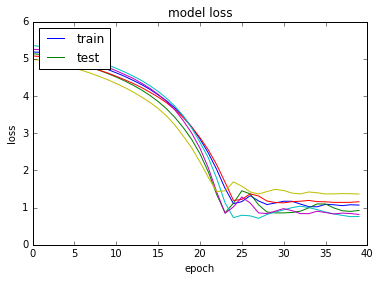

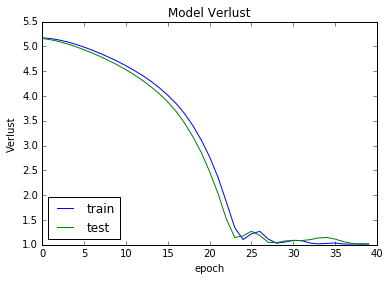

In [322]:
#Fixed Random Seed for Reproducability (ACHTUNG WEGEN LOOPED CV)
np.random.seed(seed)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.utils import np_utils
from sklearn.cross_validation import StratifiedKFold
import SCRpreprocess
import pandas as pd
from sklearn.model_selection import train_test_split


data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='subtraction', 
                                                                                          zstand=1, resolution=100)

X,y, _=what_to_predict(data, 'key', 'vpn', 'emo')

nb_filters = 50
nb_conv = 5

history=[]
acc_cv=[]
acc_val_cv=[]
loss_cv=[]
loss_val_cv=[]

#Stratified KFold (von oben!)
for train, test in kf.split(X):
    X_train=X[train]
    X_test=X[test]
    y_train=y[train]
    y_test=y[test]

    Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_length=X_train.shape[1], input_dim=1))
    model.add(MaxPooling1D())
    model.add(Convolution1D(2*nb_filters, nb_conv, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.1))
    model.add(Flatten()) 
    model.add(Dense(71, activation='relu'))
    model.add(Dense(1))
    
    #model.summary()
    from keras.optimizers import SGD
    lrate=0.001
    momentum=0.9
    sgd = SGD(lr=lrate, momentum=momentum,  nesterov=False)
    model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
    history=model.fit(Xr_train, y_train, validation_data=(Xr_test, y_test), nb_epoch=40, batch_size=20, verbose=0)
    score = model.evaluate(Xr_test, y_test)
    print 'Prediction des Modells' 
    print score
    print 'Prediction des Mean' 
    print (np.mean(np.abs(y_test-np.mean(y_train))))
    

    loss_cv.append(history.history['loss'])
    loss_val_cv.append(history.history['val_loss'])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')   
plt.show()
    
visualise_loss(loss_cv, loss_val_cv)

## Classification - not grouped

## Prediction of Valence by all Trials

In [120]:
#from sklearn.model_selection import train_test_split
#Fixed Random Seed for Reproducability (ACHTUNG WEGEN LOOPED CV)
np.random.seed(seed)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D

import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedShuffleSplit


data, scl_s, scl_b, fragebogen, MET_num, MET_cat=SCRpreprocess.get_scr_data(method='raw',
                                                                                          zstand=1, resolution=50)
X,y, idf =what_to_predict(data, 'val', 'not', 'all')

nb_filters = 50
nb_conv = 8
epochs = 5
lrate = 0.1
momentum=0


history=[]
acc_cv=[]
acc_val_cv=[]
loss_cv=[]
loss_val_cv=[]

for train, test in StratifiedShuffleSplit(y, n_iter=3, test_size=0.5):
    X_train=X[train]
    X_test=X[test]
    y_train=y[train]
    y_test=y[test]
        
    Xr_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Xr_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Convolution1D(nb_filters, nb_conv, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D())
    model.add(Convolution1D(nb_filters*2, nb_conv, activation='relu'))#, input_length=X_train.shape[1], input_dim=1))
    model.add(MaxPooling1D())
    model.add(Dropout(0.1))
    model.add(Flatten()) 
    model.add(Dense(72, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    from keras.optimizers import SGD
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)

    
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
    model.summary()
    history=model.fit(Xr_train, y_train, validation_data=(Xr_test, y_test),  
                      nb_epoch=epochs, batch_size=5, verbose=0)

    score = model.evaluate(Xr_test, y_test, batch_size=16)
    
    acc_cv.append(history.history['acc'])
    acc_val_cv.append(history.history['val_acc'])
    
    loss_cv.append(history.history['loss'])
    loss_val_cv.append(history.history['val_loss'])
    
    #print acc_cv
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train1', 'test1', 'train2', 'test2', 'train3', 'test3'], loc='upper left')

plt.show()

no outlier detection
raw
prediction of val
trialbased-prediction: take into acount dependencies!
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_5037 (Convolution1D(None, 64L, 50)       450         convolution1d_input_2519[0][0]   
____________________________________________________________________________________________________
maxpooling1d_5037 (MaxPooling1D) (None, 32L, 50)       0           convolution1d_5037[0][0]         
____________________________________________________________________________________________________
convolution1d_5038 (Convolution1D(None, 25L, 100)      40100       maxpooling1d_5037[0][0]          
____________________________________________________________________________________________________
maxpooling1d_5038 (MaxPooling1D) (None, 12L, 100)      0           convolution1d_5038[0][0]    